In [1]:
import torch
import torch.nn as nn 
from torch.nn import Conv2d,LeakyReLU,BatchNorm2d, ConvTranspose2d,ReLU
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import cv2
import os
from accelerate import Accelerator
import datetime
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
accelerator = Accelerator(cpu=False)
device = accelerator.device

In [3]:
pip install tensorboardX

Note: you may need to restart the kernel to use updated packages.


In [4]:
from tensorboardX import SummaryWriter

In [5]:
def get_transforms():
    transform = transforms.Compose([
        transforms.ToTensor(),# H,W,C -> C,H,W && [0,255] -> [0,1]
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) #[0,1] -> [-1,1]
    ])
    return transform


In [ ]:
print('hii')

In [6]:
class MYDataSet(Dataset):
    def __init__(self,src_data_path,dst_data_path):
        self.train_A_imglist = self.get_imglist(src_data_path)
        self.train_B_imglist = self.get_imglist(dst_data_path)
        self.transform = get_transforms()
    
    def get_imglist(self, img_dir):
        img_name_list = sorted(os.listdir(img_dir))
        img_list = []
        half_len = len(img_name_list) // 3
        for img_name in img_name_list[:half_len]:
            img_path = os.path.join(img_dir, img_name)
            img_list.append(img_path)
        return img_list
    
    def __len__(self):
        return len(self.train_A_imglist)
    def __getitem__(self,index):
        train_A_img_path = self.train_A_imglist[index]
        train_B_img_path = self.train_B_imglist[index]

        train_A_img = cv2.imread(train_A_img_path)
        train_B_img = cv2.imread(train_B_img_path)

        train_A_tensor = self.transform(train_A_img)
        train_B_tensor = self.transform(train_B_img)
    

        return [train_A_tensor,train_B_tensor]

In [7]:
def encoder_layer(in_channels,out_channels,kernel_size=4,stride = 2,padding = 1): # NOTE: Padding here is different from the 'vaild' in tensorflow version of original github
    layer = nn.Sequential(
        Conv2d(in_channels,out_channels,kernel_size=kernel_size,stride=stride,padding=padding),
        BatchNorm2d(out_channels),
        LeakyReLU(0.2)
    )
    return layer

In [8]:
def decoder_layer(in_channels,out_channels,last_layer=False,kernel_size=4,stride = 2,padding = 1):
    if not last_layer:
        layer = nn.Sequential(
            ConvTranspose2d(in_channels,out_channels,kernel_size=kernel_size,stride=stride,padding=padding),
            torch.nn.ReLU()
        )
    else:
        layer = nn.Sequential(
            ConvTranspose2d(in_channels,out_channels,kernel_size=4,stride=2,padding=1),
            torch.nn.Tanh()
        )
    return layer

def discrimiter_layer(in_channels,out_channels,kernel_size=4,stride = 2,padding = 1,wgan=False):
    if wgan:
        layer = nn.Sequential(
            Conv2d(in_channels,out_channels,kernel_size=kernel_size,stride=stride,padding=padding),
            BatchNorm2d(out_channels),
            LeakyReLU(0.2)
        )
    else:
        layer = nn.Sequential(
            Conv2d(in_channels,out_channels,kernel_size=kernel_size,stride=stride,padding=padding),
            LeakyReLU(0.2)
        )
    return layer


In [9]:
class GeneratorNet(torch.nn.Module):
    def __init__(self):
        super(GeneratorNet, self).__init__()

        # Encoder
        self.enc_conv1 = encoder_layer(3,64)
        self.enc_conv2 = encoder_layer(64,128)
        self.enc_conv3 = encoder_layer(128,256)
        self.enc_conv4 = encoder_layer(256,512)
        self.enc_conv5 = encoder_layer(512,512)
        self.enc_conv6 = encoder_layer(512,512)
        self.enc_conv7 = encoder_layer(512,512)
        self.enc_conv8 = encoder_layer(512,512,padding=1)
        # Decoder
        self.dec_conv1 = decoder_layer(512,512)
        self.dec_conv2 = decoder_layer(1024,512)
        self.dec_conv3 = decoder_layer(1024,512)
        self.dec_conv4 = decoder_layer(1024,512)
        self.dec_conv5 = decoder_layer(1024,256)
        self.dec_conv6 = decoder_layer(512,128)
        self.dec_conv7 = decoder_layer(256,64)
        self.dec_conv8 = decoder_layer(128,3,last_layer=True)
        
    def forward(self,input_x):
        # Encoder
        output_enc_conv1 = self.enc_conv1(input_x)
        output_enc_conv2 = self.enc_conv2(output_enc_conv1)
        output_enc_conv3 = self.enc_conv3(output_enc_conv2)
        output_enc_conv4 = self.enc_conv4(output_enc_conv3)
        output_enc_conv5 = self.enc_conv5(output_enc_conv4)
        output_enc_conv6 = self.enc_conv6(output_enc_conv5)
        output_enc_conv7 = self.enc_conv7(output_enc_conv6)
        output_enc_conv8 = self.enc_conv8(output_enc_conv7)


        #  Decoder
        output_dec_conv1 = self.dec_conv1(output_enc_conv8)
        output_dec_conv1 = torch.cat([output_dec_conv1,output_enc_conv7],dim = 1)

        output_dec_conv2 = self.dec_conv2(output_dec_conv1)
        output_dec_conv2 = torch.cat([output_dec_conv2,output_enc_conv6],dim = 1)

        output_dec_conv3 = self.dec_conv3(output_dec_conv2)
        output_dec_conv3 = torch.cat([output_dec_conv3,output_enc_conv5],dim = 1)

        output_dec_conv4 = self.dec_conv4(output_dec_conv3)
        output_dec_conv4 = torch.cat([output_dec_conv4,output_enc_conv4],dim = 1)

        output_dec_conv5 = self.dec_conv5(output_dec_conv4)
        output_dec_conv5 = torch.cat([output_dec_conv5,output_enc_conv3],dim = 1)

        output_dec_conv6 = self.dec_conv6(output_dec_conv5)
        output_dec_conv6 = torch.cat([output_dec_conv6,output_enc_conv2],dim = 1)

        output_dec_conv7 = self.dec_conv7(output_dec_conv6)
        output_dec_conv7 = torch.cat([output_dec_conv7,output_enc_conv1],dim = 1)

        output_dec_conv8 = self.dec_conv8(output_dec_conv7)

        return output_dec_conv8
      

      


In [10]:
class DiscrimiterNet(torch.nn.Module):
    def __init__(self,wgan_loss):
        super(DiscrimiterNet, self).__init__()
        self.wgan_loss = wgan_loss

        self.conv1 = discrimiter_layer(3,64,self.wgan_loss)
        self.conv2 = discrimiter_layer(64,128,self.wgan_loss)
        self.conv3 = discrimiter_layer(128,256,self.wgan_loss)
        self.conv4 = discrimiter_layer(256,512,self.wgan_loss)
        self.conv5 = discrimiter_layer(512,1,kernel_size=1,stride=1)
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        return x

In [11]:
def tensor2img(one_tensor):# [b,c,h,w] [-1,1]
    tensor = one_tensor.squeeze(0) #[c,h,w] [0,1]
    tensor = (tensor*0.5 + 0.5)*255 # [c,h,w] [0,255]
    tensor_cpu = tensor.cpu()
    img = np.array(tensor_cpu,dtype=np.uint8)
    img = np.transpose(img,(1,2,0))
    return img
def img2tensor(np_img):# [h,w,c]
    tensor = get_transforms()(np_img).cuda() # [c,h,w] [-1,1]
    tensor = tensor.unsqueeze(0) # [b,c,h,w] [-1,1]
    return tensor


def weights_init(module):
    classname = module.__class__.__name__
    if classname.find('Conv') !=-1:
        nn.init.normal_(module.weight.data,0.0,0.02)

def loss_gradient_difference(real_image,generated): # b x c x h x w
    true_x_shifted_right = real_image[:,:,1:,:]# 32 x 3 x 255 x 256
    true_x_shifted_left = real_image[:,:,:-1,:]
    true_x_gradient = torch.abs(true_x_shifted_left - true_x_shifted_right)

    generated_x_shift_right = generated[:,:,1:,:]# 32 x 3 x 255 x 256
    generated_x_shift_left = generated[:,:,:-1,:]
    generated_x_griednt = torch.abs(generated_x_shift_left - generated_x_shift_right)

    difference_x = true_x_gradient - generated_x_griednt

    loss_x_gradient = (torch.sum(difference_x**2))/2 # tf.nn.l2_loss(true_x_gradient - generated_x_gradient)

    true_y_shifted_right = real_image[:,:,:,1:]
    true_y_shifted_left = real_image[:,:,:,:-1]
    true_y_gradient = torch.abs(true_y_shifted_left - true_y_shifted_right)

    generated_y_shift_right = generated[:,:,:,1:]
    generated_y_shift_left = generated[:,:,:,:-1]
    generated_y_griednt = torch.abs(generated_y_shift_left - generated_y_shift_right)

    difference_y = true_y_gradient - generated_y_griednt
    loss_y_gradient = (torch.sum(difference_y**2))/2 # tf.nn.l2_loss(true_y_gradient - generated_y_gradient)

    igdl = loss_x_gradient + loss_y_gradient
    return igdl


def calculate_x_gradient(images):
    x_gradient_filter = torch.Tensor(
        [
            [[0, 0, 0], [-1, 0, 1], [0, 0, 0]],
            [[0, 0, 0], [-1, 0, 1], [0, 0, 0]],
            [[0, 0, 0], [-1, 0, 1], [0, 0, 0]],
        ]
    ).cuda()
    x_gradient_filter = x_gradient_filter.view(3, 1, 3, 3)
    result = torch.functional.F.conv2d(
        images, x_gradient_filter, groups=3, padding=(1, 1)
    )
    return result




def calculate_y_gradient(images):
    y_gradient_filter = torch.Tensor(
        [
            [[0, 1, 0], [0, 0, 0], [0, -1, 0]],
            [[0, 1, 0], [0, 0, 0], [0, -1, 0]],
            [[0, 1, 0], [0, 0, 0], [0, -1, 0]],
        ]
    ).cuda()
    y_gradient_filter = y_gradient_filter.view(3, 1, 3, 3)
    result = torch.functional.F.conv2d(
        images, y_gradient_filter, groups=3, padding=(1, 1)
    )
    return result

def loss_igdl( correct_images, generated_images): # taken from https://github.com/Arquestro/ugan-pytorch/blob/master/ops/loss_modules.py
    correct_images_gradient_x = calculate_x_gradient(correct_images)
    generated_images_gradient_x = calculate_x_gradient(generated_images)
    correct_images_gradient_y = calculate_y_gradient(correct_images)
    generated_images_gradient_y = calculate_y_gradient(generated_images)
    pairwise_p_distance = torch.nn.PairwiseDistance(p=1)
    distances_x_gradient = pairwise_p_distance(
        correct_images_gradient_x, generated_images_gradient_x
    )
    distances_y_gradient = pairwise_p_distance(
        correct_images_gradient_y, generated_images_gradient_y
    )
    loss_x_gradient = torch.mean(distances_x_gradient)
    loss_y_gradient = torch.mean(distances_y_gradient)
    loss = 0.5 * (loss_x_gradient + loss_y_gradient)
    return loss

In [12]:
def ToTensor(image):
    """Convert ndarrays in sample to Tensors."""
    # numpy image: H x W x C
    # torch image: C X H X W
    image = image.transpose((2, 0, 1))
    # Normalize image from [0, 255] to [0, 1]
    image = 1 / 255.0 * image
    return torch.from_numpy(image).type(dtype=torch.float)

In [ ]:
def train():
    accelerator = Accelerator(cpu=False)  # Specify GPU IDs
    device = accelerator.device
    print(device)

    # Define the argparse arguments as variables
    trainA_path = '/kaggle/input/underwater-img/underwater_imagenet/trainA'
    trainB_path = '/kaggle/input/underwater-img/underwater_imagenet/trainB'
    use_wgan = True
    lr = 1e-4
    max_epoch = 500
    bz = 8
    lbda1 = 100
    lbda2 = 1
    num_workers = 1
    checkpoints_root = 'checkpoints'
    log_root = './log'

    wgan = use_wgan
    learning_rate = lr
    max_epochs = max_epoch
    batch_size = bz
    lambda_1 = lbda1
    lambda_2 = lbda2

    netG = torch.nn.DataParallel(GeneratorNet()).to(device)
    netD = torch.nn.DataParallel(DiscrimiterNet(wgan_loss=wgan)).to(device)

    optimizer_g = optim.Adam(netG.parameters(), lr=learning_rate)
    optimizer_d = optim.Adam(netD.parameters(), lr=learning_rate)

    dataset = MYDataSet(src_data_path=trainA_path, dst_data_path=trainB_path)
    datasetloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    log_root = log_root
    date = datetime.datetime.now().strftime('%F_%T').replace(':', '_')
    log_folder = date
    log_dir = os.path.join(log_root, log_folder)
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    writer = SummaryWriter(log_dir=log_dir)

    checkpoint_root = checkpoints_root
    checkpoint_folder = date
    checkpoint_dir = os.path.join(checkpoint_root, checkpoint_folder)
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    netG, netD, optimizer_g, optimizer_d, datasetloader = accelerator.prepare(netG, netD, optimizer_g, optimizer_d, datasetloader)

    scaler = GradScaler()
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        for epoch in range(0, max_epochs):
            d_loss_log_list = []
            g_loss_log_list = []
            futures = []
            for iteration, data in enumerate(tqdm(datasetloader)):
                batchtensor_A = data[0].to(device)
                batchtensor_B = data[1].to(device)
                future = executor.submit(process_batch, batchtensor_A, batchtensor_B, netG, netD, optimizer_g, optimizer_d, wgan, device, lambda_1, lambda_2)
                futures.append(future)

            for future in futures:
                g_loss_log, d_loss_log = future.result()
                g_loss_log_list.append(g_loss_log)
                d_loss_log_list.append(d_loss_log)

            d_loss_average_log = np.array(d_loss_log_list).mean()
            g_loss_average_log = np.array(g_loss_log_list).mean()

            writer.add_scalar('D_loss_epoch', d_loss_average_log, epoch)
            writer.add_scalar('G_loss_epoch', g_loss_average_log, epoch)
            print('D_loss_epoch',d_loss_average_log)
            print('g_loss_epoch',g_loss_average_log)

    writer.close()
#fastest but due to speed system crash

In [ ]:
def train():
    accelerator = Accelerator(cpu=False)
    device = accelerator.device
    print(device)
    
    # Define the argparse arguments as variables
    trainA_path = '/kaggle/input/underwater-img/underwater_imagenet/trainA'
    trainB_path = '/kaggle/input/underwater-img/underwater_imagenet/trainB'
    use_wgan = True
    lr = 1e-4
    max_epoch = 350
    bz = 32
    lbda1 = 100
    lbda2 = 1
    num_workers = 4
    checkpoints_root = 'checkpoints'
    log_root = './log'

    if __name__ == "__main__":
        wgan = use_wgan
        learning_rate = lr
        max_epochs = max_epoch
        batch_size = bz
        lambda_1 = lbda1
        lambda_2 = lbda2

        netG = torch.nn.DataParallel(GeneratorNet()).to(device)
        netD = torch.nn.DataParallel(DiscrimiterNet(wgan_loss=wgan)).to(device)

        optimizer_g = optim.Adam(netG.parameters(), lr=learning_rate)
        optimizer_d = optim.Adam(netD.parameters(), lr=learning_rate)

        dataset = MYDataSet(src_data_path=trainA_path, dst_data_path=trainB_path)
        datasetloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        log_root = log_root
        date = datetime.datetime.now().strftime('%F_%T').replace(':', '_')
        log_folder = date
        log_dir = os.path.join(log_root, log_folder)
        if not os.path.exists(log_dir):
            os.makedirs(log_dir)
        writer = SummaryWriter(log_dir=log_dir)

        checkpoint_root = checkpoints_root
        checkpoint_folder = date
        checkpoint_dir = os.path.join(checkpoint_root, checkpoint_folder)
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        netG, netD, optimizer_g, optimizer_d, datasetloader = accelerator.prepare(netG, netD, optimizer_g, optimizer_d, datasetloader)

        for epoch in range(0, max_epochs):
            print("epoch :",epoch+1)
            d_loss_log_list = []
            g_loss_log_list = []
            for iteration, data in enumerate(tqdm(datasetloader)):
                batchtensor_A = data[0].to(device)
                batchtensor_B = data[1].to(device)
                generated_batchtensor = netG(batchtensor_A)

                num_critic = 1 if not wgan else 5
                for i in range(num_critic):
                    optimizer_d.zero_grad()
                    d_fake = netD(generated_batchtensor.detach())
                    d_real = netD(batchtensor_B)

                    d_loss = torch.mean(d_fake) - torch.mean(d_real)
                    if wgan:
                        lambda_gp = 10
                        epsilon = torch.rand(batchtensor_B.size()[0], 1, 1, 1).to(device)
                        x_hat = batchtensor_B * epsilon + (1 - epsilon) * generated_batchtensor
                        d_hat = netD(x_hat)
                        gradients = torch.autograd.grad(outputs=d_hat, inputs=x_hat, grad_outputs=torch.ones_like(d_hat), create_graph=True, retain_graph=True)[0]
                        gradients = gradients.view(gradients.size(0), -1)
                        gradient_penalty = lambda_gp * ((gradients.norm(2, dim=1) - 1) ** 2).mean()
                        d_loss += gradient_penalty

                    accelerator.backward(d_loss,retain_graph=True)
                    optimizer_d.step()
                    d_loss_log = d_loss.item()
                    d_loss_log_list.append(d_loss_log)

                optimizer_g.zero_grad()
                d_fake = netD(generated_batchtensor)

                g_loss = -torch.mean(d_fake)
                l1_loss = torch.mean(torch.abs(generated_batchtensor - batchtensor_B))
                igdl_loss = loss_igdl(batchtensor_B, generated_batchtensor)
                g_loss += lambda_1 * l1_loss + lambda_2 * igdl_loss

                accelerator.backward(g_loss)
                optimizer_g.step()

                g_loss_log = g_loss.item()
                g_loss_log_list.append(g_loss_log)

                writer.add_scalar('G_loss', g_loss_log, (epoch * len(datasetloader) + iteration))
                writer.add_scalar('D_loss', d_loss_log, (epoch * len(datasetloader) + iteration))

            d_loss_average_log = np.array(d_loss_log_list).mean()
            g_loss_average_log = np.array(g_loss_log_list).mean()

            writer.add_scalar('D_loss_epoch', d_loss_average_log, epoch)
            writer.add_scalar('G_loss_epoch', g_loss_average_log, epoch)
            print('D_loss_epoch',d_loss_average_log)
            print('g_loss_epoch',g_loss_average_log)
            if (epoch + 1) % 50 == 0:
                torch.save({
                    'epoch': epoch,
                    'netG_state_dict': netG.state_dict(),
                    'netD_state_dict': netD.state_dict(),
                    'optimizer_g_state_dict': optimizer_g.state_dict(),
                    'optimizer_d_state_dict': optimizer_d.state_dict(),
                    'g_loss': g_loss_log_list[-1],
                    'd_loss': d_loss_log_list[-1],
                }, f"checkpoint_epoch_{epoch + 1}.pth")

        writer.close()


In [ ]:
from accelerate import notebook_launcher

notebook_launcher(train,num_processes=1)

In [ ]:
import zipfile
import os
from IPython.display import FileLink

def zip_dir(directory = os.curdir, file_name = 'directory.zip'):
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

In [ ]:
zip_dir()

In [ ]:
checkpoint_path = "/kaggle/input/major-models/checkpoint_epoch_350.pth"  # Specify the path to your checkpoint file
checkpoint = torch.load(checkpoint_path)

In [ ]:
netG = GeneratorNet()

# Load the checkpoint file
checkpoint_path = "/kaggle/input/major-models/checkpoint_epoch_350.pth"  # Update with your checkpoint path
checkpoint = torch.load(checkpoint_path)

# Extract only the keys relevant to the model's state_dict
state_dict = {}
for key, value in checkpoint.items():
    if key.startswith('netG'):
        state_dict[key.replace('netG_', '')] = value

# Load the generator state_dict from the extracted state_dict
netG.load_state_dict(state_dict)

In [ ]:
# Assuming GeneratorNet is your model class
netG = GeneratorNet()

# Load the checkpoint file
checkpoint_path = "/kaggle/input/major-models/checkpoint_epoch_350.pth"  # Update with your checkpoint path
checkpoint = torch.load(checkpoint_path)

# Extract the nested state_dict if present
if 'state_dict' in checkpoint:
    state_dict = checkpoint['state_dict']
else:
    state_dict = checkpoint

# Load the generator state_dict
netG.load_state_dict(state_dict)

In [15]:
netG = GeneratorNet()

In [ ]:
netG.load_state_dict(torch.load('/kaggle/input/major-models/checkpoint_epoch_350.pth'))

In [13]:
model_path ='/kaggle/input/major-models/checkpoint_epoch_350.pth'
checkpoint = torch.load(model_path)

In [16]:
# Assuming 'model' is your model instance
model_dict = netG.state_dict()
new_state_dict = {}
for k, v in checkpoint['netG_state_dict'].items():
    if k in model_dict:
        new_state_dict[k] = v
        
        
for k, v in checkpoint['netG_state_dict'].items():
    name = k[7:]  # remove 'module.' prefix
    if name in model_dict:
        new_state_dict[name] = v        
# Load the newly created state dict

new_model = GeneratorNet().cuda()
for name, param in new_model.named_parameters():
    if name in model_dict:
        model_dict[name].copy_(param)
        
        
        
new_model.load_state_dict(new_state_dict)




<All keys matched successfully>

In [17]:
import torch
import torch.nn as nn 
import cv2, os
import numpy as np
from tqdm import tqdm_notebook as tqdm

# Directly specify the input and output folders
img_folder = '/kaggle/input/underwater-img/underwater_imagenet/test'
checkpoint_path = '/kaggle/input/major-models/checkpoint_epoch_300.pth'
output_folder = '/kaggle/working/out'

if __name__ == "__main__":
    with torch.no_grad():
        pbar = tqdm(os.listdir(img_folder))
        for img_name in os.listdir(img_folder):
            img_path = os.path.join(img_folder, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (512, 512))
            img_tensor = img2tensor(img)
            output_tensor = new_model.forward(img_tensor)
            output_img = tensor2img(output_tensor)
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)
            save_path = os.path.join(output_folder, img_name)
            cv2.imwrite(save_path, output_img)
            pbar.update(1)


/tmp/ipykernel_35/3575008161.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(os.listdir(img_folder))


  0%|          | 0/1813 [00:00<?, ?it/s]

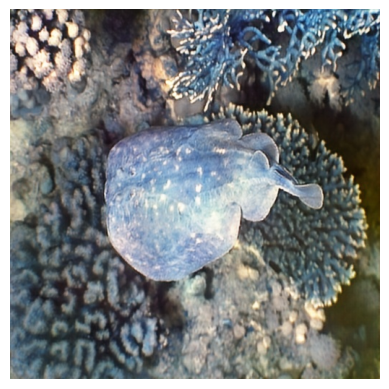

In [18]:
import os
import cv2
import matplotlib.pyplot as plt

# Path to the directory containing the images
output_dir = '/kaggle/working/out/n01496331_13322.jpg'
img = cv2.imread(output_dir)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)# Convert to RGB for displaying with matplotlib
plt.imshow(img)
plt.axis('off')
plt.show()


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Path to the directory containing the images
output_dir = '/kaggle/input/underwater-img/underwater_imagenet/test'

# Get the list of files in the directory
files = os.listdir(output_dir)

# Display the first five images
for file in files[:5]:
    file_path = os.path.join(output_dir, file)
    img = cv2.imread(file_path) # Convert to RGB for displaying with matplotlib
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [23]:
if __name__ == "__main__":
    with torch.no_grad():
        img_path = '/kaggle/input/underwater-img/underwater_imagenet/test/n01496331_13322.jpg'
        img = cv2.imread(img_path)
        img = cv2.resize(img, (512, 512))
        img_tensor = img2tensor(img)
        output_tensor = new_model.forward(img_tensor)
        output_img = tensor2img(output_tensor)
        output_path = '/kaggle/working/output.jpg'
        cv2.imwrite(output_path, output_img)
